In [1]:
import numpy as np 
from neuron import PyramidalCells
import matplotlib.pyplot as plt
%matplotlib inline

/scratch/fstella/felix/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/matplotlibrc


In [2]:
def simulate_run(len_track = 200, av_running_speed = 20, dt = 0.01, tn = 1000):
    bins = np.arange(0., len_track)
    fps = 1/dt
    n_runs = int(2*tn/(len_track/av_running_speed))

    x = np.array([])
    i = 0
    while True:
        stopping_time = np.random.uniform(0, 1, 2)
        stop1 = np.ones((int(stopping_time[0]*fps),)) * 0.
        speed = av_running_speed + np.random.randn() * 5
        run_length = len(bins) * fps / speed
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time[1]*fps),)) * (len(bins)-1.)
        speed = av_running_speed + np.random.randn() * 5
        run_length = len(bins) * fps / speed
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
        if len(x) >= tn*fps:
            break
        i += 1

    x = x[:int(tn*fps)]
    t = np.arange(len(x))/fps

    return t, x

def get_firing_rates(pyramidal, event_count, x_run):

    firing_rates = np.zeros((event_count.shape[1], 1024))
    x_run_reshaped = np.zeros(1024)
    step_size = len(event_count)//firing_rates.shape[1]
    
    for i in range(firing_rates.shape[1]):
        firing_rates[:, i] = np.sum(event_count[i * step_size:(i + 1) * step_size, :], axis = 0) / (step_size*pyramidal.dt)
        x_run_reshaped[i] = np.mean(x_run[i * step_size:(i + 1) * step_size])

    return firing_rates, x_run_reshaped


def get_activation_map(firing_rates, m_EC, x_run_reshaped, top_down = True):

    out = np.zeros((firing_rates.shape[0], 32))
    position_bins = np.linspace(0, x_run_reshaped.max(), 32)

    for idx, pos in enumerate(x_run_reshaped):
        bin_idx = np.argmin(np.abs(position_bins - pos))
        if out[:, bin_idx].sum() == 0:
            out[:, bin_idx] = firing_rates[:, idx] 
        else: 
            out[:, bin_idx] = (out[:, bin_idx] + firing_rates[:, idx]) / 2

    if top_down:
        sort_TD = np.argsort(m_EC)
    else:
        weighted_vals = out * np.arange(out.shape[1])[np.newaxis, :]
        m_EC = weighted_vals.sum(axis=1) / out.sum(axis=1)
        sort_TD = np.argsort(m_EC) 
        
    mean_firing_rates = out[np.ix_(sort_TD, np.arange(out.shape[1]))]

    return mean_firing_rates


def plot_firing_rates(fig, ax, firing_rates, m_EC, out, x_run_reshaped, top_down = True):

    ###### TODO:  IDEALLY I WOULD SOMEHOW PUT IT IN BINS ACCORDING TO POSITION AND THEN MEAN OVER THAT

    mean_firing_rates = get_activation_map(firing_rates, m_EC, x_run_reshaped, top_down = top_down)

    extent = [0, 100, 0, mean_firing_rates.shape[0]]
    n_active = np.sum(mean_firing_rates.sum(axis = 1) != 0)
    im = ax.imshow(mean_firing_rates, aspect='auto', extent=extent, origin='lower')
    fig.colorbar(im, ax=ax)
    ax.set_title(f"{out}; neurons active: {n_active}")
    ax.set_xlabel("Position (cm)")
    ax.set_ylabel("Neuron")

    return fig, ax, n_active


def simulate_for_env(pyramidal, len_track, speed, dt, tn, t_epoch, top_down, retrieval, new_env):
    t_run, x_run = simulate_run(len_track, speed, dt, tn)

    if retrieval:
        event_count, _ = pyramidal.retrieve_place_cells(t_run, x_run, new_env, a = 0, t_per_epoch = None, top_down = False)
    else:
        event_count, _ = pyramidal.learn_place_cells(t_run, x_run, t_epoch, top_down = top_down)
    firing_rates, x_run_reshaped = get_firing_rates(pyramidal, event_count, x_run)
    mean_firing_rates = get_activation_map(firing_rates, pyramidal.m_EC, x_run_reshaped, top_down = top_down)

    return t_run, x_run, firing_rates, mean_firing_rates, x_run_reshaped

200 120.0
200 120.0
199 120.0
187 120.0
161 120.0
136 120.0


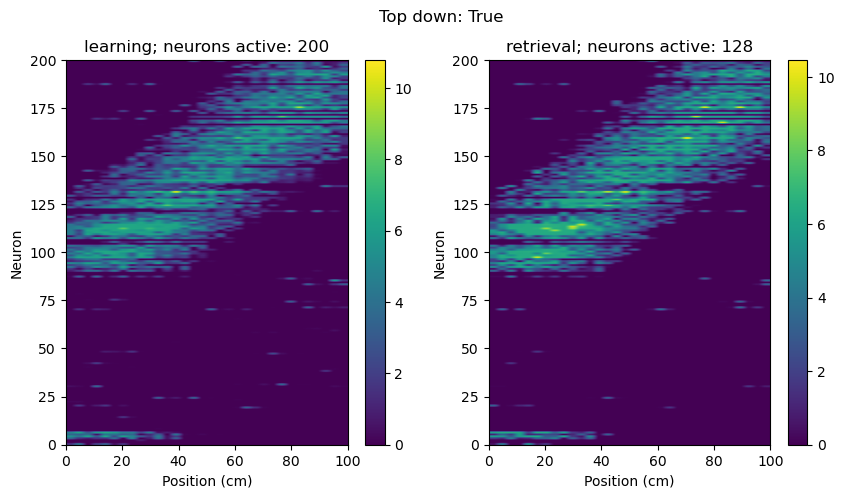

199 120.0
199 120.0
197 120.0
187 120.0
186 120.0
182 120.0


/tmp/ipykernel_594207/2516222923.py:57: RuntimeWarning: invalid value encountered in divide
  m_EC = weighted_vals.sum(axis=1) / out.sum(axis=1)


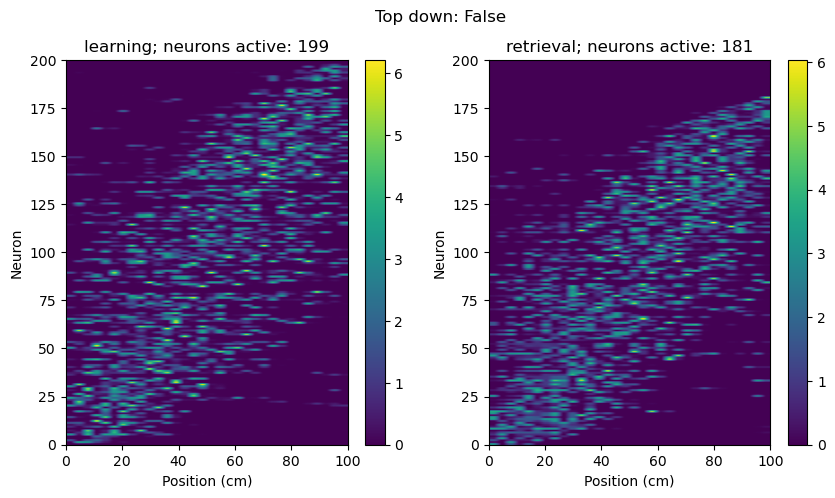

In [3]:

lr = 5e-1
t_epoch = 0.5
speed = 20
len_track = 100. 
dt = 0.001
tn = len_track/speed*32
n_cells = {'pyramidal' : 200, 'inter_a' : 20, 'inter_b' : 20, 'CA3' : 120}
n_sim = 10
top_down = True
p_active = (.3, 0.6)

for top_down in (True, False):
    pyramidal = PyramidalCells(n_cells, learning_rate=lr, dt = dt, p_active = p_active)
    pyramidal.alpha = 0 if top_down else .1
    pyramidal.epsilon = .1

    _, _, fr_learning, mean_firing_rates_learning, x_run_l = simulate_for_env(pyramidal, len_track, speed, dt, tn, t_epoch, 
                                                                    top_down, retrieval = False, new_env = False)

    _, _, fr_rt, mean_firing_rates_retriev, x_run_r = simulate_for_env(pyramidal, len_track, speed, dt, tn, t_epoch,
                                                            top_down, retrieval = True, new_env = False)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Top down: {str(top_down)}")
    plot_firing_rates(fig, ax[0], fr_learning, pyramidal.m_EC, f'learning', x_run_l, top_down = top_down)
    plot_firing_rates(fig, ax[1], fr_rt, pyramidal.m_EC, f'retrieval', x_run_r, top_down = top_down)
    plt.show()


TypeError: plot_firing_rates() missing 1 required positional argument: 'x_run_reshaped'

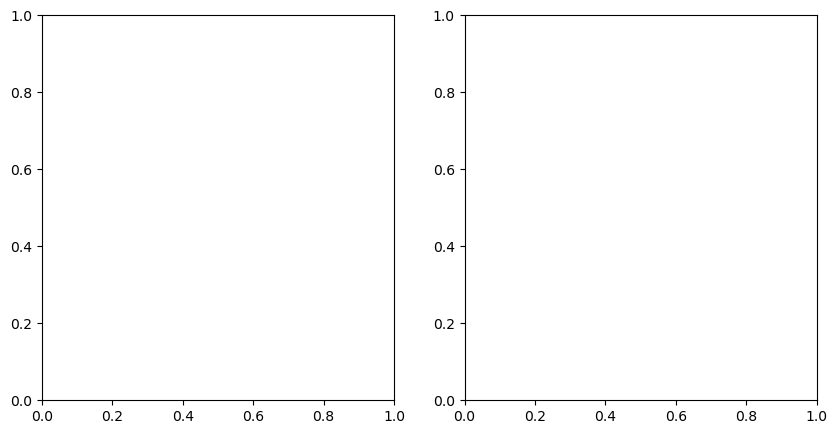

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_firing_rates(fig, ax[0], fr_learning, pyramidal.m_EC, out='learning', top_down = top_down)
plot_firing_rates(fig, ax[1], fr_rt, pyramidal.m_EC, out='retrieval', top_down = top_down)
plt.show()

In [6]:
n_active = np.sum(mean_firing_rates_learning.sum(axis = 1) != 0)
print(np.sum(mean_firing_rates_learning.mean(axis = 1) > 1), np.sum(mean_firing_rates_retriev.mean(axis = 1) != 0))

66 103
